In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['origdecepreview', 'glove-global-vectors-for-word-representation']


In [2]:
from __future__ import print_function
from keras.preprocessing.text import text_to_word_sequence
import pandas as pd
from keras.preprocessing.text import Tokenizer
import numpy as np
from bs4 import BeautifulSoup
import logging
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, MaxPooling1D, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

Using TensorFlow backend.


In [3]:
data = pd.read_csv('../input/origdecepreview/deceptive-opinion.csv')

In [4]:
data.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...


In [5]:
df = data[['deceptive','polarity','text']]                            #df[['C', 'D', 'E']]

In [6]:
df1 = df.sample(frac=1)

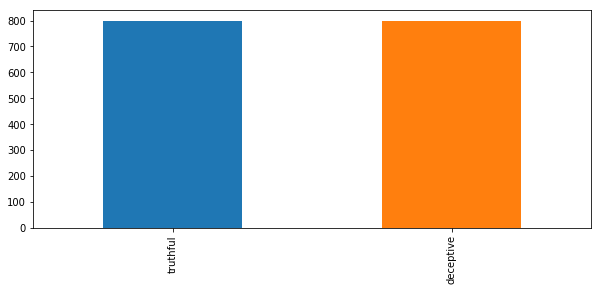

In [7]:
import matplotlib.pyplot as plt 
my_tags = ['deceptive','truthful']
plt.figure(figsize=(10,4))
df1.deceptive.value_counts().plot(kind='bar');

Text(0, 0.5, 'Polarity')

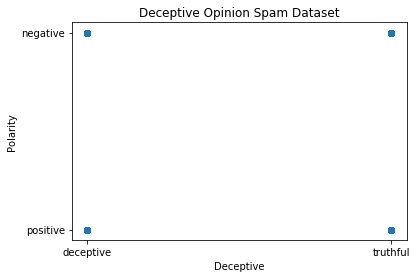

In [8]:
fig, ax = plt.subplots()

# scatter the sepal_length against the sepal_width
ax.scatter(df1['deceptive'], df1['polarity'])
# set a title and labels
ax.set_title('Deceptive Opinion Spam Dataset')
ax.set_xlabel('Deceptive')
ax.set_ylabel('Polarity')

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 583 to 1065
Data columns (total 3 columns):
deceptive    1600 non-null object
polarity     1600 non-null object
text         1600 non-null object
dtypes: object(3)
memory usage: 50.0+ KB


In [15]:
df1.head()

,deceptive,polarity,text
583,deceptive,positive,"'Classy','Decent' and 'Serene'. these words cl..."
1420,deceptive,negative,I booked my weekend Chicago stay at the Hard R...
771,deceptive,positive,The InterContinental Chicago is located in the...
1455,deceptive,negative,"Having made regular business trips to Chicago,..."
820,truthful,negative,"no bell boys there when you need them, sully s..."


In [16]:
df2=df1.drop(columns=['polarity'],axis=1)

In [17]:
df2.describe()

,deceptive,text
count,1600,1600
unique,2,1596
top,truthful,Very disappointed in our stay in Chicago Monoc...
freq,800,2


In [18]:
# Import label encoder 
from sklearn import preprocessing 

# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 

# Encode labels in column 'species'. 
df2['deceptive']= label_encoder.fit_transform(df2['deceptive']) 

df2['deceptive'].unique() 


array([0, 1])

In [19]:
df2.head()

,deceptive,text
583,0,"'Classy','Decent' and 'Serene'. these words cl..."
1420,0,I booked my weekend Chicago stay at the Hard R...
771,0,The InterContinental Chicago is located in the...
1455,0,"Having made regular business trips to Chicago,..."
820,1,"no bell boys there when you need them, sully s..."


In [20]:
df2.describe()

,deceptive
count,1600.000000
mean,0.500000
std,0.500156
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [21]:
from nltk.corpus import stopwords

In [22]:
import re

In [23]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower().split()
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+\-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text
    
df2['text'] = df2['text'].apply(clean_text)

In [24]:
X = df2.text
y = df2.deceptive

In [25]:
X = X.map(lambda a: clean_text(a))

In [26]:
def text_to_wordlist(text):    
    #Remove Special Characters
    text = re.sub(r'[^a-z\d ]', " ", text)
    text = re.sub(r'\d+', '_num_', text)    
    return(text)

In [27]:
X = X.map(lambda a: text_to_wordlist(a))

In [28]:
train, test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [29]:
tokenizer = Tokenizer(num_words=None,lower=True,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=' ',char_level=False)

In [30]:
tokenizer.fit_on_texts(X)

In [31]:
x_train = tokenizer.texts_to_sequences(train)

In [32]:
x_test = tokenizer.texts_to_sequences(test)

In [33]:
word_index = tokenizer.word_index

In [34]:
X = tokenizer.texts_to_sequences(X)

In [35]:
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in X)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in X])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in X])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))

Vocab size: 9340
Longest comment size: 795
Average comment size: 150.633125
Stdev of comment size: 88.63532607112344
Max comment size: 416


In [36]:
from keras.preprocessing.sequence import pad_sequences

In [37]:
processed_post_x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
processed_post_x_test = pad_sequences(x_test, maxlen=max_len, padding='post', truncating='post')

In [38]:
processed_x_train = pad_sequences(x_train, maxlen=max_len)
processed_x_test = pad_sequences(x_test, maxlen=max_len)

In [39]:
print('x_train shape:', processed_x_train.shape)
print('x_test shape:', processed_x_test.shape)

x_train shape: (1200, 416)
x_test shape: (400, 416)


In [40]:
import keras.backend
from keras.models import Sequential, load_model
from keras.layers import CuDNNGRU, Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization, LSTM
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Nadam
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

In [41]:
import os

In [42]:
embeddings_index = {}
f = open(os.path.join('../input/glove-global-vectors-for-word-representation', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [43]:
embedding_dim = 100
k = 0
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        k += 1
        embedding_matrix[i] = embedding_vector

In [44]:
# Initate model
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(60, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(LSTM(30, return_sequences=True, name='lstm_layer2'))#kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='sigmoid',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
#model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 416, 100)          934100    
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 416, 60)           38640     
_________________________________________________________________
lstm_layer2 (LSTM)           (None, 416, 30)           10920     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 416, 128)          11648     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 138, 128)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
__________

In [45]:
#adam = keras.optimizers.Adam(lr=0.03, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [46]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [47]:
history = model.fit(processed_x_train,y_train,validation_data=(processed_x_test,y_test),epochs=15,batch_size=32,verbose=1)

Train on 1200 samples, validate on 400 samples
Epoch 1/15
1200/1200 [==============================] - 32s 27ms/step - loss: 18.2728 - acc: 0.5525 - val_loss: 13.2678 - val_acc: 0.5425
Epoch 2/15
1200/1200 [==============================] - 27s 22ms/step - loss: 10.0725 - acc: 0.6508 - val_loss: 7.1750 - val_acc: 0.8175
Epoch 3/15
1200/1200 [==============================] - 27s 23ms/step - loss: 5.5473 - acc: 0.6950 - val_loss: 4.0551 - val_acc: 0.6700
Epoch 4/15
1200/1200 [==============================] - 26s 22ms/step - loss: 3.1460 - acc: 0.7017 - val_loss: 2.3024 - val_acc: 0.8050
Epoch 5/15
1200/1200 [==============================] - 26s 22ms/step - loss: 1.9005 - acc: 0.7300 - val_loss: 1.4878 - val_acc: 0.7500
Epoch 6/15
1200/1200 [==============================] - 26s 22ms/step - loss: 1.2319 - acc: 0.7958 - val_loss: 1.0232 - val_acc: 0.8150
Epoch 7/15
1200/1200 [==============================] - 26s 21ms/step - loss: 0.9068 - acc: 0.8167 - val_loss: 0.8361 - val_acc: 0.800

In [48]:
model.evaluate(processed_x_test,y_test)

400/400 [==============================] - 1s 4ms/step


[0.7146950101852417, 0.7875]

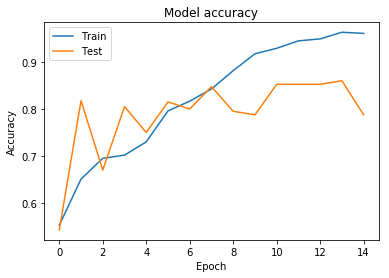

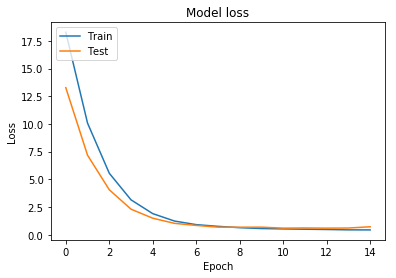

In [49]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**CNN GLoVe **

In [50]:
model_glove = Sequential()
model_glove.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(BatchNormalization())
model_glove.add(LSTM(100,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model_glove.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))

model_glove.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 416, 100)          934100    
_________________________________________________________________
dropout_4 (Dropout)          (None, 416, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 412, 64)           32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 103, 64)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 103, 64)           256       
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total para

In [51]:
model_glove.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [52]:
history = model_glove.fit(processed_x_train,y_train,validation_data=(processed_x_test,y_test),epochs=30,batch_size=32,verbose=1)

Train on 1200 samples, validate on 400 samples
Epoch 1/30
1200/1200 [==============================] - 9s 8ms/step - loss: 2.8114 - acc: 0.6008 - val_loss: 2.1338 - val_acc: 0.6100
Epoch 2/30
1200/1200 [==============================] - 6s 5ms/step - loss: 1.6845 - acc: 0.7300 - val_loss: 1.4806 - val_acc: 0.6825
Epoch 3/30
1200/1200 [==============================] - 6s 5ms/step - loss: 1.1725 - acc: 0.8008 - val_loss: 1.5101 - val_acc: 0.5750
Epoch 4/30
1200/1200 [==============================] - 6s 5ms/step - loss: 0.8868 - acc: 0.8650 - val_loss: 1.2953 - val_acc: 0.5475
Epoch 5/30
1200/1200 [==============================] - 6s 5ms/step - loss: 0.7518 - acc: 0.8917 - val_loss: 1.0261 - val_acc: 0.6675
Epoch 6/30
1200/1200 [==============================] - 6s 5ms/step - loss: 0.6028 - acc: 0.9433 - val_loss: 1.0124 - val_acc: 0.6625
Epoch 7/30
1200/1200 [==============================] - 6s 5ms/step - loss: 0.5503 - acc: 0.9467 - val_loss: 0.7756 - val_acc: 0.8300
Epoch 8/30
1200

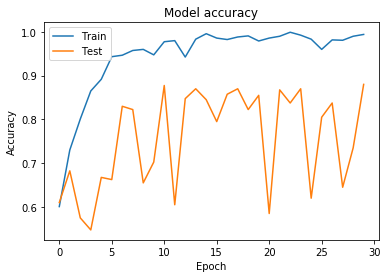

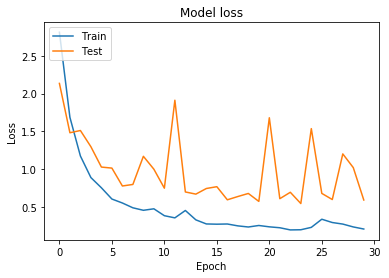

In [53]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

2 LayreLSTM

In [54]:
# Initate model
model_lstm = Sequential()


model_lstm.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))

input_shape = embedding_matrix[0].shape


model_lstm.add(LSTM(60, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model_lstm.add(LSTM(30, return_sequences=True, name='lstm_layer2'))#kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
#model_lstm.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
#model_lstm.add(MaxPooling1D(3))
#model_lstm.add(GlobalMaxPooling1D())
model_lstm.add(BatchNormalization())
model_lstm.add(Flatten())
model_lstm.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(32, activation='sigmoid',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model_lstm.add(Dropout(0.3))
#model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
model.add(Dense(20, activation='relu', input_shape=input_shape))
#model.add(Dense(20, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 416, 100)          934100    
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 416, 60)           38640     
_________________________________________________________________
lstm_layer2 (LSTM)           (None, 416, 30)           10920     
_________________________________________________________________
batch_normalization_3 (Batch (None, 416, 30)           120       
_________________________________________________________________
flatten_1 (Flatten)          (None, 12480)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                798784    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
__________

In [55]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [56]:
hist = model_lstm.fit(processed_x_train,y_train,validation_data=(processed_x_test,y_test),epochs=15,batch_size=32,verbose=1)

Train on 1200 samples, validate on 400 samples
Epoch 1/15
1200/1200 [==============================] - 29s 24ms/step - loss: 11.9936 - acc: 0.4950 - val_loss: 6.1268 - val_acc: 0.5325
Epoch 2/15
1200/1200 [==============================] - 25s 20ms/step - loss: 4.9547 - acc: 0.6150 - val_loss: 3.9150 - val_acc: 0.6300
Epoch 3/15
1200/1200 [==============================] - 25s 21ms/step - loss: 3.1504 - acc: 0.7433 - val_loss: 2.5269 - val_acc: 0.7000
Epoch 4/15
1200/1200 [==============================] - 25s 21ms/step - loss: 2.0219 - acc: 0.8133 - val_loss: 2.0638 - val_acc: 0.6350
Epoch 5/15
1200/1200 [==============================] - 25s 21ms/step - loss: 1.2884 - acc: 0.8642 - val_loss: 1.2858 - val_acc: 0.6750
Epoch 6/15
1200/1200 [==============================] - 26s 21ms/step - loss: 0.8754 - acc: 0.9067 - val_loss: 0.8732 - val_acc: 0.8250
Epoch 7/15
1200/1200 [==============================] - 26s 22ms/step - loss: 0.5784 - acc: 0.9333 - val_loss: 0.6989 - val_acc: 0.8225


In [ ]:
# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()